In [1]:
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
from scipy.stats.stats import pearsonr

# SK-LEARN
from sklearn.metrics import *
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

# Data Normalization
from sklearn import preprocessing

In [2]:
# READ DATASET
df = pd.read_csv("dataset/training.csv")

In [3]:
# Missing Values Replacement
print "Check Missing Values pre-replacement\n"
print df.isnull().sum()

# Replacement Missing Values with NS
df.replace({'Trim' : { np.nan : 'NS'}}, inplace=True)
df.replace({'SubModel' : { np.nan : 'NS'}}, inplace=True)
df.replace({'Color' : { np.nan : 'NS'}}, inplace=True)
df.replace({'Transmission' : { np.nan : 'NS'}}, inplace=True)
df.replace({'WheelTypeID' : { np.nan : 'NS'}}, inplace=True)
df.replace({'WheelType' : { np.nan : 'NS'}}, inplace=True)
df.replace({'Nationality' : { np.nan : 'NS'}}, inplace=True)
df.replace({'Size' : { np.nan : 'NS'}}, inplace=True)
df.replace({'TopThreeAmericanName' : { np.nan : 'NS'}}, inplace=True)
df.replace({'MMRAcquisitionAuctionAveragePrice' : { np.nan : 'NS'}}, inplace=True)
df.replace({'MMRAcquisitionAuctionCleanPrice' : { np.nan : 'NS'}}, inplace=True)
df.replace({'MMRAcquisitionRetailAveragePrice' : { np.nan : 'NS'}}, inplace=True)
df.replace({'MMRAcquisitonRetailCleanPrice' : { np.nan : 'NS'}}, inplace=True)
df.replace({'MMRCurrentAuctionAveragePrice' : { np.nan : 'NS'}}, inplace=True)
df.replace({'MMRCurrentAuctionCleanPrice' : { np.nan : 'NS'}}, inplace=True)
df.replace({'MMRCurrentRetailAveragePrice' : { np.nan : 'NS'}}, inplace=True)
df.replace({'MMRCurrentRetailCleanPrice' : { np.nan : 'NS'}}, inplace=True)
df.replace({'PRIMEUNIT' : { np.nan : 'NS'}}, inplace=True)
df.replace({'AUCGUART' : { np.nan : 'NS'}}, inplace=True)

# Resolve Ambiguity of some attributes and drop not necessary attributes
# Transmission => 'Manual' and 'MANUAL'
print "# # # # # # # # # # # # # # #\n"
print "Transmission Ambiguity\n"
print df['Transmission'].unique()

df['Transmission'] = df['Transmission'].str.upper()

print "\n", df['Transmission'].unique()
print "\nResolve ambiguities done\n"

# Drop Vehicle Year because is redundant with Vehicle Age
print "# # # # # # # # # # # # # # #\n"
print "Redundant and not necessary Attributes\n"

df = df.drop('PurchDate', axis=1)

print "PurchDate dropped\n"

df = df.drop('VehYear',axis=1)

print "VehYear is redundant, dropped\n"

print "WheelTypeID", sorted(df['WheelTypeID'].unique())

df = df.drop('WheelTypeID', axis=1)

print "WheelTypeID is redudant, dropped\n"

df = df.drop('TopThreeAmericanName', axis=1)

print "TopThreeAmericanName dropped\n"

df = df.drop('BYRNO', axis=1)

print "BYRNO (ID assigned to buyer) dropped\n"

# Replace NS Nationality for Manufactures with the appropriate nationality
# DODGE => AMERICAN
# GMC => AMERICAN
# JEEP => AMERICAN
# HYUNDAI => OTHER ASIAN

print "# # # # # # # # # # # # # # #\n"
print "Replace NS Nationality with appropriate nationality based on Make\n"

print "DODGE => AMERICAN | GMC => AMERICAN | JEEP => AMERICAN | HYUNDAI => OTHER ASIAN\n"

# Replace DODGE
df.ix[(df.Make == 'DODGE') & (df.Nationality == 'NS'),'Nationality'] = 'AMERICAN'
# Replace GMC
df.ix[(df.Make == 'GMC') & (df.Nationality == 'NS'),'Nationality'] = 'AMERICAN'
# Replace JEEP
df.ix[(df.Make == 'JEEP') & (df.Nationality == 'NS'),'Nationality'] = 'AMERICAN'
# Replace HYNDAI
df.ix[(df.Make == 'HYUNDAI') & (df.Nationality == 'NS'),'Nationality'] = 'OTHER ASIAN'

print "Nationalities replacement done!\n"
print "Check if there are NS nationalities...\n"

if df[df['Nationality'] == 'NS'].empty:
    print "All NS nationalities are replaced!\n"
else:
    print "There are NS nationalities need to be replaced!\n"

# Replace NS Sizes for Model with the appropriate Size

print "# # # # # # # # # # # # # # #\n"
print "Replace NS Sizes with appropriate size based on Make and Model\n"

# GMC SIERRA => LARGE TRUCK
df.ix[(df.Make == 'GMC') & (df['Model'].str.contains('SIERRA')),'Size'] = 'LARGE TRUCK'
# DODGE NITRO => MEDIUM SUV
df.ix[(df.Make == 'DODGE') & (df['Model'].str.contains('NITRO')),'Size'] = 'MEDIUM SUV'
# HYUNDAI ELANTRA => MEDIUM
df.ix[(df.Make == 'HYUNDAI') & (df['Model'].str.contains('ELANTRA')),'Size'] = 'MEDIUM'
# JEEP PATRIOT => SMALL SUV
df.ix[(df.Make == 'JEEP') & (df['Model'].str.contains('PATRIOT')),'Size'] = 'SMALL SUV'

print "Sizes replacement done!\n"
print "Check if there are NS Sizes\n"

if df[df['Size'] == 'NS'].empty:
    print "All NS sizes are replaced!\n"
else:
    print "There are NS sizes need to be replaced!\n"

print "# # # # # # # # # # # # # # #\n"
print "\nCheck Missing Values post-replacement and without dropped attributes\n"
print df.isnull().sum()

Check Missing Values pre-replacement

RefId                                    0
IsBadBuy                                 0
PurchDate                                0
Auction                                  0
VehYear                                  0
VehicleAge                               0
Make                                     0
Model                                    0
Trim                                  2360
SubModel                                 8
Color                                    8
Transmission                             9
WheelTypeID                           3169
WheelType                             3174
VehOdo                                   0
Nationality                              5
Size                                     5
TopThreeAmericanName                     5
MMRAcquisitionAuctionAveragePrice       18
MMRAcquisitionAuctionCleanPrice         18
MMRAcquisitionRetailAveragePrice        18
MMRAcquisitonRetailCleanPrice           18
MMRCurrentAuctio

In [4]:
# Attributes Arrays and Samples

# RefId not considered
# IsBadBuy not considered
# PurchDate dropped
auctions = sorted(df['Auction'].unique())
# VehYear dropped
vehicleAges = sorted(df['VehicleAge'].unique())
makes = sorted(df['Make'].unique())
models = sorted(df['Model'].unique())
trims = sorted(df['Trim'].unique())
subModels = sorted(df['SubModel'].unique())
colors = sorted(df['Color'].unique())
transmissions = sorted(df['Transmission'].unique())
# WheelTypeID dropped
wheeltypes = sorted(df['WheelType'].unique())
vehOdos = sorted(df['VehOdo'].unique())
nationalities = sorted(df['Nationality'].unique())
sizes = sorted(df['Size'].unique())
# TopThreeAmericanName dropped
# MMRAcquisitionAuctionAveragePrice not considered
# MMRAcquisitionAuctionCleanPrice not considered
# MMRAcquisitionRetailAveragePrice not considered
# MMRAcquisitonRetailCleanPrice not considered
# MMRCurrentAuctionAveragePrice not considered
# MMRCurrentAuctionCleanPrice not considered
# MMRCurrentRetailAveragePrice not considered
# MMRCurrentRetailCleanPrice not considered
demands = sorted(df['PRIMEUNIT'].unique())
guarantees = sorted(df['AUCGUART'].unique())
# BYRNO dropped 
zipcodes = sorted(df['VNZIP1'].unique())    #VNZIP1
states = sorted(df['VNST'].unique())        #VNST
vehcosts = sorted(df['VehBCost'].unique())
onlinesales = sorted(df['IsOnlineSale'].unique())
warranties = sorted(df['WarrantyCost'].unique())

# Samples
print "Sample of sorted unique rows for each attribute\n"
print auctions[:5],"\n",vehicleAges[:5],"\n",makes[:5],"\n",models[:5],"\n",trims[:5],"\n",subModels[:5],"\n",colors[:5],"\n",transmissions[:5],"\n",\
    wheeltypes[:5],"\n",vehOdos[:5],"\n",nationalities[:5],"\n",sizes[:5],"\n",demands[:5],"\n",guarantees[:5],"\n",zipcodes[:5],"\n",states[:5],"\n", \
    vehcosts[:5],"\n",onlinesales[:5],"\n",warranties[:5],"\n"

Sample of sorted unique rows for each attribute

['ADESA', 'MANHEIM', 'OTHER'] 
[0, 1, 2, 3, 4] 
['ACURA', 'BUICK', 'CADILLAC', 'CHEVROLET', 'CHRYSLER'] 
['1500 RAM PICKUP 2WD', '1500 RAM PICKUP 4WD', '1500 SIERRA PICKUP 2', '1500 SIERRA PICKUP 4', '1500 SILVERADO PICKU'] 
['1', '150', '2', '250', '3'] 
['2D CONVERTIBLE', '2D CONVERTIBLE DREAM CRUISER', '2D CONVERTIBLE GL', '2D CONVERTIBLE GLS', '2D CONVERTIBLE GT'] 
['BEIGE', 'BLACK', 'BLUE', 'BROWN', 'GOLD'] 
['AUTO', 'MANUAL', 'NS'] 
['Alloy', 'Covers', 'NS', 'Special'] 
[4825, 5368, 8706, 9446, 9878] 
['AMERICAN', 'OTHER', 'OTHER ASIAN', 'TOP LINE ASIAN'] 
['COMPACT', 'CROSSOVER', 'LARGE', 'LARGE SUV', 'LARGE TRUCK'] 
['NO', 'NS', 'YES'] 
['GREEN', 'NS', 'RED'] 
[2764, 3106, 8505, 12552, 16066] 
['AL', 'AR', 'AZ', 'CA', 'CO'] 
[1.0, 225.0, 1400.0, 1620.0, 1720.0] 
[0, 1] 
[462, 482, 505, 522, 533] 



In [5]:
# Data Normalization - Part 1
# Dictionaries with integer values mapping for no-integer attributes

print "\nnot-numeric attributes\n"
print df.dtypes[df.dtypes.map(lambda x: x == 'object')]

# Assign to no-integer parameters integer values (assign an integer ID)
# Need for clustering algorithms because they working only with numeric values
auctionsDictionary = dict(zip(auctions,range(0, len(auctions)+1)))
makesDictionary = dict(zip(makes,range(0, len(makes)+1)))
modelsDictionary = dict(zip(models,range(0, len(models)+1)))
trimsDictionary = dict(zip(trims,range(0, len(trims)+1)))
subModelsDictionary = dict(zip(subModels,range(0, len(subModels)+1)))
colorsDictionary = dict(zip(colors,range(0, len(colors)+1)))
transmissionsDictionary = dict(zip(transmissions,range(0, len(transmissions)+1)))
wheeltypesDictionary = dict(zip(wheeltypes,range(0, len(wheeltypes)+1)))
nationalitiesDictionary = dict(zip(nationalities,range(0, len(nationalities)+1)))
sizesDictionary = dict(zip(sizes,range(0, len(sizes)+1)))
demandsDictionary = dict(zip(demands,range(0, len(demands)+1)))
guaranteesDictionary = dict(zip(guarantees,range(0, len(guarantees)+1)))
vehcostsDictionary = dict(zip(vehcosts,range(0, len(vehcosts)+1)))  #not object but mapped as dictionary
zipcodesDictionary = dict(zip(zipcodes,range(0, len(zipcodes)+1)))  #not object but mapped as dictionary
statesDictionary = dict(zip(states,range(0, len(states)+1)))
warrantiesDictionary = dict(zip(warranties,range(0, len(warranties)+1)))    #not object but mapped as dictionary

print "\n Dictionaries for mapping object attributes (Samples)\n"
print \
    dict(auctionsDictionary.items()[0:5]),\
    "\n",\
    dict(makesDictionary.items()[0:5]),\
    "\n",\
    dict(modelsDictionary.items()[0:5]),\
    "\n",\
    dict(trimsDictionary.items()[0:5]),\
    "\n",\
    dict(subModelsDictionary.items()[0:5]),\
    "\n",\
    dict(colorsDictionary.items()[0:5]),\
    "\n",\
    dict(transmissionsDictionary.items()[0:5]),\
    "\n",\
    dict(wheeltypesDictionary.items()[0:5]),\
    "\n",\
    dict(nationalitiesDictionary.items()[0:5]),\
    "\n",\
    dict(sizesDictionary.items()[0:5]),\
    "\n",\
    dict(demandsDictionary.items()[0:5]),\
    "\n",\
    dict(guaranteesDictionary.items()[0:5]),\
    "\n",\
    dict(vehcostsDictionary.items()[0:5]),\
    "\n",\
    dict(zipcodesDictionary.items()[0:5]),\
    "\n",\
    dict(statesDictionary.items()[0:5]),\
    "\n",\
    dict(warrantiesDictionary.items()[0:5]),\
    "\n",\

#Mapping Dictionaries to main DataFrame
df['AuctionVal'] = df['Auction'].map(auctionsDictionary)
df['MakeVal'] = df['Make'].map(makesDictionary)
df['ModelVal'] = df['Model'].map(modelsDictionary)
df['TrimVal'] = df['Trim'].map(trimsDictionary)
df['SubModelVal'] = df['SubModel'].map(subModelsDictionary)
df['ColorVal'] = df['Color'].map(colorsDictionary)
df['TransmissionVal'] = df['Transmission'].map(transmissionsDictionary)
df['WheelTypeVal'] = df['WheelType'].map(wheeltypesDictionary)
df['NationalityVal'] = df['Nationality'].map(nationalitiesDictionary)
df['SizeVal'] = df['Size'].map(sizesDictionary)
df['PRIMEUNITVal'] = df['PRIMEUNIT'].map(demandsDictionary)
df['AUCGUARTVal'] = df['AUCGUART'].map(guaranteesDictionary)
df['VehBCostVal'] = df['VehBCost'].map(vehcostsDictionary)
df['VNZIP1Val'] = df['VNZIP1'].map(zipcodesDictionary)
df['VNSTVal'] = df['VNST'].map(statesDictionary)
df['WarrantyCostVal'] = df['WarrantyCost'].map(warrantiesDictionary)

print "\nMapping dictionaries to new attribute columns, done.\n"

# NOTA
# DataFrame['X'].map() per ogni elemento i della colonna X cerca nel dizionario passato come argomento a map()
# il valore associato all'elemento i (utilizzato come chiave di ricerca) e restituisce una serie. (Dizionario => "key" : "value")
# la serie viene poi assegnata ad una nuova colonna del dataframe.


not-numeric attributes

Auction                              object
Make                                 object
Model                                object
Trim                                 object
SubModel                             object
Color                                object
Transmission                         object
WheelType                            object
Nationality                          object
Size                                 object
MMRAcquisitionAuctionAveragePrice    object
MMRAcquisitionAuctionCleanPrice      object
MMRAcquisitionRetailAveragePrice     object
MMRAcquisitonRetailCleanPrice        object
MMRCurrentAuctionAveragePrice        object
MMRCurrentAuctionCleanPrice          object
MMRCurrentRetailAveragePrice         object
MMRCurrentRetailCleanPrice           object
PRIMEUNIT                            object
AUCGUART                             object
VNST                                 object
dtype: object

 Dictionaries for mapping object att

In [6]:
# Feature (Attributes) Selection for clustering 

# Feature selection is a process where you automatically select those features in your data that contribute most to the prediction variable or output in which you are interested.
#
# Having too many irrelevant features in your data can decrease the accuracy of the models. 
# Three benefits of performing feature selection before modeling your data are:
#
# Reduces Overfitting: Less redundant data means less opportunity to make decisions based on noise.
# Improves Accuracy: Less misleading data means modeling accuracy improves.
# Reduces Training Time: Less data means that algorithms train faster.
#
# Two different feature selection methods provided by the scikit-learn Python library are Recursive Feature Elimination and feature importance ranking.

dfFeatureSelection = pd.concat([
    #df['IsBadBuy'],
    df['VehicleAge'],
    df['VehOdo'],
    df['VehBCost'],
    df['AuctionVal'],
    df['MakeVal'],
    df['WheelTypeVal'],
    df['NationalityVal'],
    df['VNSTVal'],
    df['WarrantyCostVal']
    ],
    axis=1)

print dfFeatureSelection.columns
nAttributesRanking = len(dfFeatureSelection.columns)
print "\nNumber of attributes for ranking: ", nAttributesRanking

# Separate the data from the target attributes
data = dfFeatureSelection.values
target = df['IsBadBuy'].values
names = dfFeatureSelection.columns
# Data Normalization
# normalize the data attributes
normalized_data = preprocessing.normalize(data)
# standardize the data attributes
standardized_data = preprocessing.scale(data)

print "\nData Normalized and Standardized, done.\n"

# Recursive Feature Elimination
#
# The Recursive Feature Elimination (RFE) method is a feature selection approach. 
# It works by recursively removing attributes and building a model on those attributes that remain. 
# It uses the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute.
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# create a base classifier used to evaluate a subset of attributes
model = LogisticRegression()
# create the RFE model and select 3 attributes
rfe = RFE(model, 3)
rfe = rfe.fit(data, target)

# summarize the selection of the attributes
#print(rfe.support_)
#print(rfe.ranking_)
print "Recursive Feature Elimination (RFE) - Features sorted by their rank:"
print sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), names))

#

Index([u'VehicleAge', u'VehOdo', u'VehBCost', u'AuctionVal', u'MakeVal',
       u'WheelTypeVal', u'NationalityVal', u'VNSTVal', u'WarrantyCostVal'],
      dtype='object')

Number of attributes for ranking:  9

Data Normalized and Standardized, done.

Recursive Feature Elimination (RFE) - Features sorted by their rank:
[(1.0, 'AuctionVal'), (1.0, 'VehicleAge'), (1.0, 'WheelTypeVal'), (2.0, 'NationalityVal'), (3.0, 'VNSTVal'), (4.0, 'MakeVal'), (5.0, 'VehBCost'), (6.0, 'WarrantyCostVal'), (7.0, 'VehOdo')]


In [6]:
# Models for Clustering

# Model 1
dfCluster1 = pd.concat([
    df['VehicleAge'],
    df['VehOdo'],
    #df['IsBadBuy'],     # mah?! e' il target
    df['IsOnlineSale'],
    df['AuctionVal'],
    df['MakeVal'],
    df['ModelVal'],
    df['TrimVal'],
    df['SubModelVal'],
    df['ColorVal'],
    df['TransmissionVal'],
    df['WheelTypeVal'],
    df['NationalityVal'],
    df['SizeVal'],
    df['PRIMEUNITVal'],
    df['AUCGUARTVal'],
    df['VehBCostVal'],
    df['VNZIP1Val'],
    df['VNSTVal'],
    df['WarrantyCostVal']
    ],
    axis=1)

# Number of Parameters in Model 1
nParams1 = len(dfCluster1.columns)

# Model 2
dfCluster2 = pd.concat([
    #df['IsBadBuy'],
    df['VehicleAge'],
    df['VehOdo'],
    df['VehBCost'],
    df['AuctionVal'],
    df['MakeVal'],
    df['WheelTypeVal'],
    df['NationalityVal'],
    df['VNSTVal'],
    df['WarrantyCostVal']
    ],
    axis=1)

# Number of Parameters in Model 2
nParams2 = len(dfCluster2.columns)

print "Model 1\n", dfCluster1.columns
print "Model 2\n", dfCluster2.columns

Model 1
Index([u'VehicleAge', u'VehOdo', u'IsOnlineSale', u'AuctionVal', u'MakeVal',
       u'ModelVal', u'TrimVal', u'SubModelVal', u'ColorVal',
       u'TransmissionVal', u'WheelTypeVal', u'NationalityVal', u'SizeVal',
       u'PRIMEUNITVal', u'AUCGUARTVal', u'VehBCostVal', u'VNZIP1Val',
       u'VNSTVal', u'WarrantyCostVal'],
      dtype='object')
Model 2
Index([u'VehicleAge', u'VehOdo', u'VehBCost', u'AuctionVal', u'MakeVal',
       u'WheelTypeVal', u'NationalityVal', u'VNSTVal', u'WarrantyCostVal'],
      dtype='object')


In [7]:
print dfCluster1.columns.values

['VehicleAge' 'VehOdo' 'IsOnlineSale' 'AuctionVal' 'MakeVal' 'ModelVal'
 'TrimVal' 'SubModelVal' 'ColorVal' 'TransmissionVal' 'WheelTypeVal'
 'NationalityVal' 'SizeVal' 'PRIMEUNITVal' 'AUCGUARTVal' 'VehBCostVal'
 'VNZIP1Val' 'VNSTVal' 'WarrantyCostVal']


In [8]:
# Data Normalization - Part 2
min_max_scaler = preprocessing.MinMaxScaler()
print min_max_scaler

# Model 1
for k in dfCluster1.columns:
    dfCluster1[k] = min_max_scaler.fit_transform(dfCluster1[k].values.astype(float))

# Model 2    
for k in dfCluster2.columns:
    dfCluster2[k] = min_max_scaler.fit_transform(dfCluster2[k].values.astype(float))
    
print "\nClustering Normalization, done. (Feature Scaling)\n"

MinMaxScaler(copy=True, feature_range=(0, 1))

Clustering Normalization, done. (Feature Scaling)



C:\Users\giulen\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\giulen\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\giulen\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single 

In [9]:
# Convert from DataFrame to Numpy Array
# sklearn library use Numpy Arrays in clustering data

# Model 1
cluster1Array = dfCluster1.values
# Model 2
cluster2Array = dfCluster2.values

print "\nNumpy Arrays for clustering Data with sk-learn library\n"
print "Model 1\n"
print cluster1Array[:1]
print "\nModel 2\n"
print cluster2Array[:1]


Numpy Arrays for clustering Data with sk-learn library

Model 1

[[ 0.33333333  0.75948671  0.          0.          0.53125     0.55178908
   0.99253731  0.25608343  0.8125      0.          0.          0.66666667
   0.45454545  0.5         0.5         0.49203283  0.30921053  0.13888889
   0.25      ]]

Model 2

[[ 0.33333333  0.75948671  0.15613178  0.          0.53125     0.
   0.66666667  0.13888889  0.25      ]]


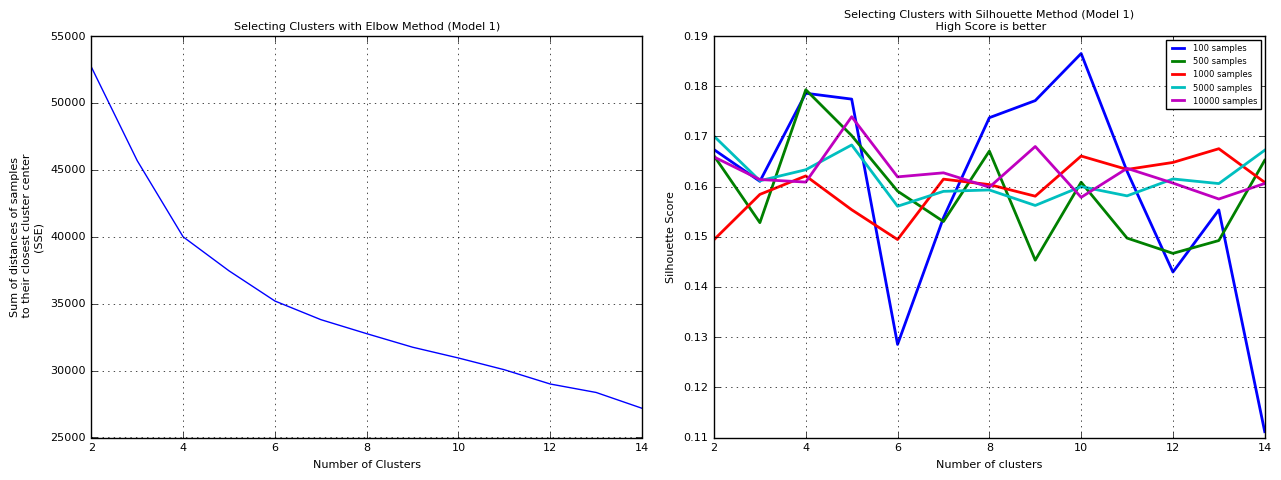

In [20]:
# Model 1
# Determining the number of clusters in a data set
# Indicate the best number of clusters to choose

fig = plt.figure(figsize=(13,5))
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))

# METHOD 1: Selecting k cluster with Elbow Method
# kmeans params
# inertia_ : Sum of distances of samples to their closest cluster center (SSE Error).
# Calculate SSE Error for Elbow Method
sse_list = []
sse_max_k = 15
for k in range(2,sse_max_k):
    kmeans1 = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans1.fit(cluster1Array)
    sse = kmeans1.inertia_
    sse_list.append(sse)
    
ax1.plot(range(2,sse_max_k), sse_list)
ax1.set_title("Selecting Clusters with Elbow Method (Model 1)",fontsize=8)
ax1.set_xlabel("Number of Clusters",fontsize=8)
ax1.set_ylabel("Sum of distances of samples\n to their closest cluster center\n(SSE)",fontsize=8)
ax1.tick_params(axis='x', labelsize=8)
ax1.tick_params(axis='y', labelsize=8)
ax1.grid()

# METHOD 2 - Silhouette
# Silhouette Score change with number of samples
nSamples = [100,500,1000,5000,10000]
for nSample in nSamples:
    silhouette_list = []
    silhouette_max_k = 15   # clusters
    for k in range(2,silhouette_max_k):
        kmeans2 = KMeans(n_clusters=silhouette_max_k)
        kmeans2.fit(cluster1Array)

        labels = kmeans2.labels_
        centroids = kmeans2.cluster_centers_

        silhouette_list.append(silhouette_score(cluster1Array, labels, sample_size=nSample, metric='euclidean'))

    ax2.plot(range(2,silhouette_max_k), silhouette_list, label=str(nSample)+' samples', linewidth=2)
    
ax2.set_ylabel("Silhouette Score",fontsize=8)
ax2.set_xlabel("Number of clusters",fontsize=8)
ax2.set_title("Selecting Clusters with Silhouette Method (Model 1)\n High Score is better",fontsize=8)
ax2.tick_params(axis='x', labelsize=8)
ax2.tick_params(axis='y', labelsize=8)
ax2.legend(fontsize=6)
ax2.grid()

plt.tight_layout()

# Save plot image
plt.savefig('saved_plots/plots_clustering_elbow_silh_model_1.png')

plt.show()

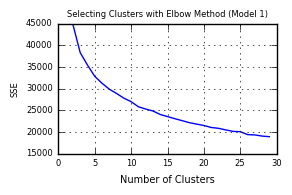

In [23]:
# Plot Dimension
plt.figure(figsize=(3,2))
ax1 = plt.subplot(111)

# METHOD 1: Selecting k cluster with Elbow Method
# kmeans params
# inertia_ : Sum of distances of samples to their closest cluster center (SSE Error).
# Calculate SSE Error for Elbow Method
sse_list = []
sse_max_k = 30
for k in range(2,sse_max_k):
    kmeans1 = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans1.fit(cluster1Array)
    sse = kmeans1.inertia_
    sse_list.append(sse)
    
ax1.plot(range(2,sse_max_k), sse_list)
ax1.set_title("Selecting Clusters with Elbow Method (Model 1)",fontsize=6)
ax1.set_xlabel("Number of Clusters",fontsize=7)
ax1.set_ylabel("SSE",fontsize=6)
ax1.tick_params(axis='x', labelsize=6)
ax1.tick_params(axis='y', labelsize=6)
ax1.grid()

plt.tight_layout()

# Save plot image
plt.savefig('saved_plots/plots_clustering_elbow_model_1.png')

plt.show()

K-MEANS Clustering (Model 1)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=6, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

Centroids for Clustering with K-MEANS (Model 1)

[0.47596413429282031, 0.5974585637357871, 0.026607185533337008, 0.50223054249980248, 0.23169013383255818, 0.47304881164502793, 0.43243632074630434, 0.3213523674683067, 0.88222436867673537, 0.017724846650203345, 0.18441806739424996, 0.0049125043150609615, 0.37503530485288139, 0.47693778379670237, 0.47685812156456608, 0.43610779334732269, 0.61016081289017354, 0.11450560733599652, 0.34343725461187469]


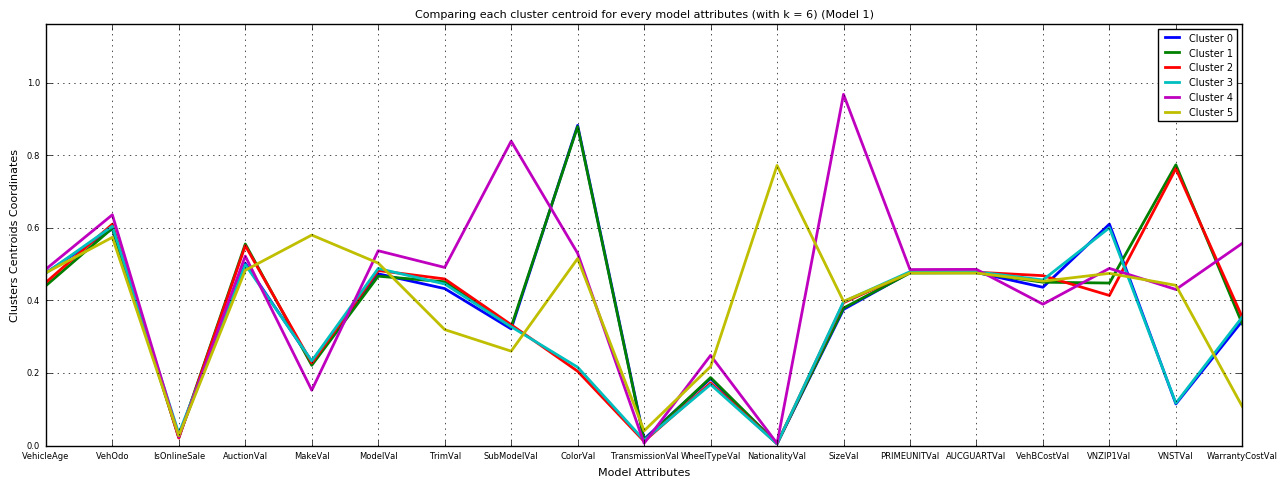

In [49]:
fig = plt.figure(figsize=(13,5))
ax1 = plt.subplot2grid((1,1), (0,0))

# K-MEANS
nClusters = 6
kmeans = KMeans(n_clusters = nClusters)

# Loading Data
kmeans.fit(cluster1Array)

print "K-MEANS Clustering (Model 1)\n"
print kmeans
print "\nCentroids for Clustering with K-MEANS (Model 1)\n"
print list(kmeans.cluster_centers_[0])

# NOTA
# Per ogni Cluster (k) viene stampato un grafico (identificato dal colore)
# Nell'asse delle X sono presenti gli attributi utilizzati nella clusterizzazione e nell'asse delle Y i loro centroidi (uno per cluster)
# Se una variabile ha molti centroidi simili tra di loro significa che non e' adatta alla clusterizzazione, poiche' ogni cluster si sovrappone a quell'altro
# La variabile 'Transmission' non e' adatta perche dal data_understanding si nota che il 96% delle auto sono con il cambio automatico e di conseguenza i cluster 
# avranno i centroidi quasi tutti uguali poiche' raggruppano esclusivamente con il cambio automatico i dati
# Importante notare nel data_understanding come si distribuiscono i valori delle variabili in esame

for i in range(0, nClusters):
    ax1.plot(range(0, nParams1), kmeans.cluster_centers_[i], label='Cluster %s' % i, linewidth=2)
    
title = 'Comparing each cluster centroid for every model attributes (with k = '+str(nClusters)+') (Model 1)'
ax1.set_title(title, fontsize=8)
ax1.set_xticks(range(0,nParams1))
ax1.set_xticklabels(list(dfCluster1.columns))
ax1.tick_params(axis='x', labelsize=6)
ax1.tick_params(axis='y', labelsize=6)
ax1.set_xlabel('Model Attributes',fontsize=8)
ax1.set_ylabel('Clusters Centroids Coordinates',fontsize=8)
ax1.set_ylim([0, (np.amax(kmeans.cluster_centers_))* 1.2])
ax1.legend(fontsize=7)
ax1.grid()

plt.tight_layout()

# Save plot image
plt.savefig('saved_plots/plots_clustering_centroids_model_1.png')

plt.show()

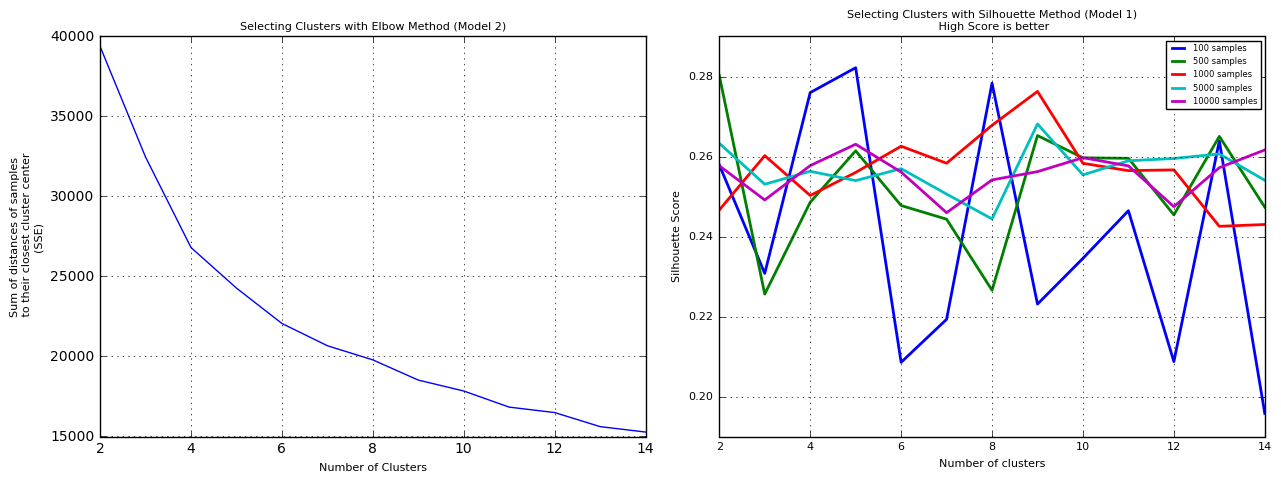

In [23]:
# Model 2

fig = plt.figure(figsize=(13,5))
ax1 = plt.subplot2grid((1,2), (0,0))
ax2 = plt.subplot2grid((1,2), (0,1))

sse_list = []
sse_max_k = 15
for k in range(2,sse_max_k):
    kmeans1 = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans1.fit(cluster2Array)
    sse = kmeans1.inertia_
    sse_list.append(sse)
    
ax1.plot(range(2,sse_max_k), sse_list)
ax1.set_title("Selecting Clusters with Elbow Method (Model 2)",fontsize=8)
ax1.set_xlabel("Number of Clusters",fontsize=8)
ax1.set_ylabel("Sum of distances of samples\n to their closest cluster center\n(SSE)",fontsize=8)
ax1.grid()

# Silhouette Score change with number of samples
nSamples = [100,500,1000,5000,10000]
for nSample in nSamples:
    silhouette_list = []
    silhouette_max_k = 15   # clusters
    for k in range(2,silhouette_max_k):
        kmeans2 = KMeans(n_clusters=silhouette_max_k)
        kmeans2.fit(cluster2Array)

        labels = kmeans2.labels_
        centroids = kmeans2.cluster_centers_

        silhouette_list.append(silhouette_score(cluster2Array, labels, sample_size=nSample, metric='euclidean'))

    ax2.plot(range(2,silhouette_max_k), silhouette_list, label=str(nSample)+' samples', linewidth=2)
    
ax2.set_ylabel("Silhouette Score",fontsize=8)
ax2.set_xlabel("Number of clusters",fontsize=8)
ax2.set_title("Selecting Clusters with Silhouette Method (Model 2)\n High Score is better",fontsize=8)
ax2.tick_params(axis='x', labelsize=8)
ax2.tick_params(axis='y', labelsize=8)
ax2.legend(fontsize=6)
ax2.grid()

plt.tight_layout()

# Save plot image
plt.savefig('saved_plots/plots_clustering_elbow_silh_model_2.png')

plt.show()

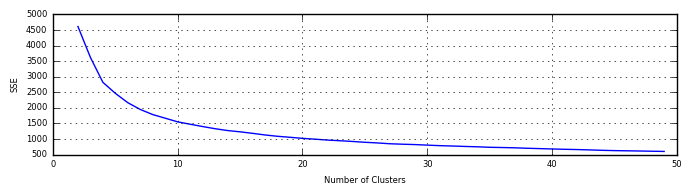

In [12]:
# Plot Dimension
plt.figure(figsize=(7,2))
ax1 = plt.subplot(111)

sse_list = []
sse_max_k = 50
for k in range(2,sse_max_k):
    kmeans1 = KMeans(init='k-means++', n_clusters=k, n_init=10, max_iter=100)
    kmeans1.fit(cluster2Array)
    sse = kmeans1.inertia_
    sse_list.append(sse)
    
ax1.plot(range(2,sse_max_k), sse_list)
#ax1.set_title("Selecting Clusters with Elbow Method",fontsize=6)
ax1.set_xlabel("Number of Clusters",fontsize=6)
ax1.set_ylabel("SSE",fontsize=6)
ax1.tick_params(axis='x', labelsize=6)
ax1.tick_params(axis='y', labelsize=6)
ax1.grid()

plt.tight_layout()

# Save plot image
plt.savefig('saved_plots/plots_clustering_elbow_model2.png')

plt.show()

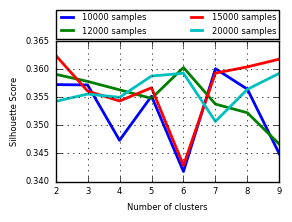

In [11]:
# Plot Dimension
plt.figure(figsize=(3,2))
ax2 = plt.subplot(111)

# Silhouette Score change with number of samples
nSamples = [10000,12000,15000,20000]
for nSample in nSamples:
    silhouette_list = []
    silhouette_max_k = 10   # clusters
    for k in range(2,silhouette_max_k):
        kmeans2 = KMeans(n_clusters=silhouette_max_k)
        kmeans2.fit(cluster2Array)

        labels = kmeans2.labels_
        centroids = kmeans2.cluster_centers_

        silhouette_list.append(silhouette_score(cluster2Array, labels, sample_size=nSample, metric='euclidean'))

    ax2.plot(range(2,silhouette_max_k), silhouette_list, label=str(nSample)+' samples', linewidth=2)
    
ax2.set_ylabel("Silhouette Score",fontsize=6)
ax2.set_xlabel("Number of clusters",fontsize=6)
#ax2.set_title("Selecting Clusters with Silhouette Method (Model 2)\n High Score is better",fontsize=8)
ax2.tick_params(axis='x', labelsize=6)
ax2.tick_params(axis='y', labelsize=6)
ax2.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.,fontsize=6)
ax2.grid()

plt.tight_layout()

# Save plot image
plt.savefig('saved_plots/plots_clustering_silhouette_vehodo_warranty.png')

plt.show()

K-MEANS Clustering (Model 2)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=8, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

Centroids for Clustering with K-MEANS (Model 2)

[0.4477045157361127, 0.58698419073158692, 0.14406187968909326, 1.0000000000000233, 0.21442245687571182, 0.21333763232844416, 0.00059111182761953374, 0.11147831694343158, 0.35718719052992826]


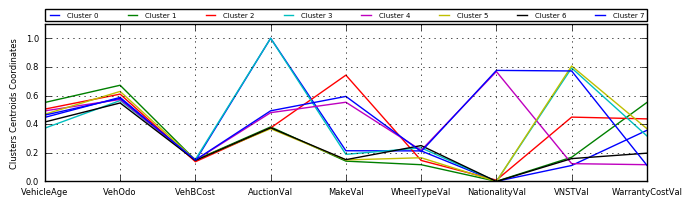

In [11]:
fig = plt.figure(figsize=(7,2))
ax1 = plt.subplot2grid((1,1), (0,0))

# K-MEANS
nClusters = 8
kmeans = KMeans(n_clusters = nClusters)

# Loading Data
kmeans.fit(cluster2Array)

print "K-MEANS Clustering (Model 2)\n"
print kmeans
print "\nCentroids for Clustering with K-MEANS (Model 2)\n"
print list(kmeans.cluster_centers_[0])

# NOTA
# Per ogni Cluster (k) viene stampato un grafico (identificato dal colore)
# Nell'asse delle X sono presenti gli attributi utilizzati nella clusterizzazione e nell'asse delle Y i loro centroidi (uno per cluster)
# Se una variabile ha molti centroidi simili tra di loro significa che non e' adatta alla clusterizzazione, poiche' ogni cluster si sovrappone a quell'altro
# La variabile 'Transmission' non e' adatta perche dal data_understanding si nota che il 96% delle auto sono con il cambio automatico e di conseguenza i cluster 
# avranno i centroidi quasi tutti uguali poiche' raggruppano esclusivamente con il cambio automatico i dati
# Importante notare nel data_understanding come si distribuiscono i valori delle variabili in esame

for i in range(0, nClusters):
    ax1.plot(range(0, nParams2), kmeans.cluster_centers_[i], label='Cluster %s' % i, linewidth=1)
    
title = 'Comparing each cluster centroid for every model attributes (with k = '+str(nClusters)+')'
#ax1.set_title(title, fontsize=8)
ax1.set_xticks(range(0,nParams2))
ax1.set_xticklabels(list(dfCluster2.columns))
ax1.tick_params(axis='x', labelsize=6)
ax1.tick_params(axis='y', labelsize=6)
#ax1.set_xlabel('Model Attributes',fontsize=6)
ax1.set_ylabel('Clusters Centroids Coordinates',fontsize=6)
ax1.set_ylim([0, (np.amax(kmeans.cluster_centers_))* 1.1])
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=8, mode="expand", borderaxespad=0.,fontsize=5)
ax1.grid()

plt.tight_layout()

# Save plot image
plt.savefig('saved_plots/plots_clustering_centroids_model_2.png')

plt.show()

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

def plot_clusters(data, algorithm, args, kwds):
    
    plt.figure(figsize=(4,4))
    ax1 = plt.subplot(111)
    ax1.set_axis_bgcolor('white')
    
    #plt.gca().set_axis_bgcolor('white')
    
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    
    ax1.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    #ax1.set_title(title, fontsize=8)
    ax1.tick_params(axis='x', labelsize=6)
    ax1.tick_params(axis='y', labelsize=6)
    ax1.set_xlabel('',fontsize=6)
    ax1.set_ylabel('',fontsize=6)
    ax1.grid()
    
    #plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    #frame = plt.gca()
    #frame.axes.get_xaxis().set_visible(True)
    #frame.axes.get_yaxis().set_visible(True)
    
    #plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=8)
    #plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=5)
    
    plt.tight_layout()
    plt.show()
    
plot_clusters(cluster2Array, cluster.KMeans, (), {'n_clusters':8})

plt.savefig('saved_plots/plots_clustering_kmeans_vehodo_warranty.png')

KeyboardInterrupt: 

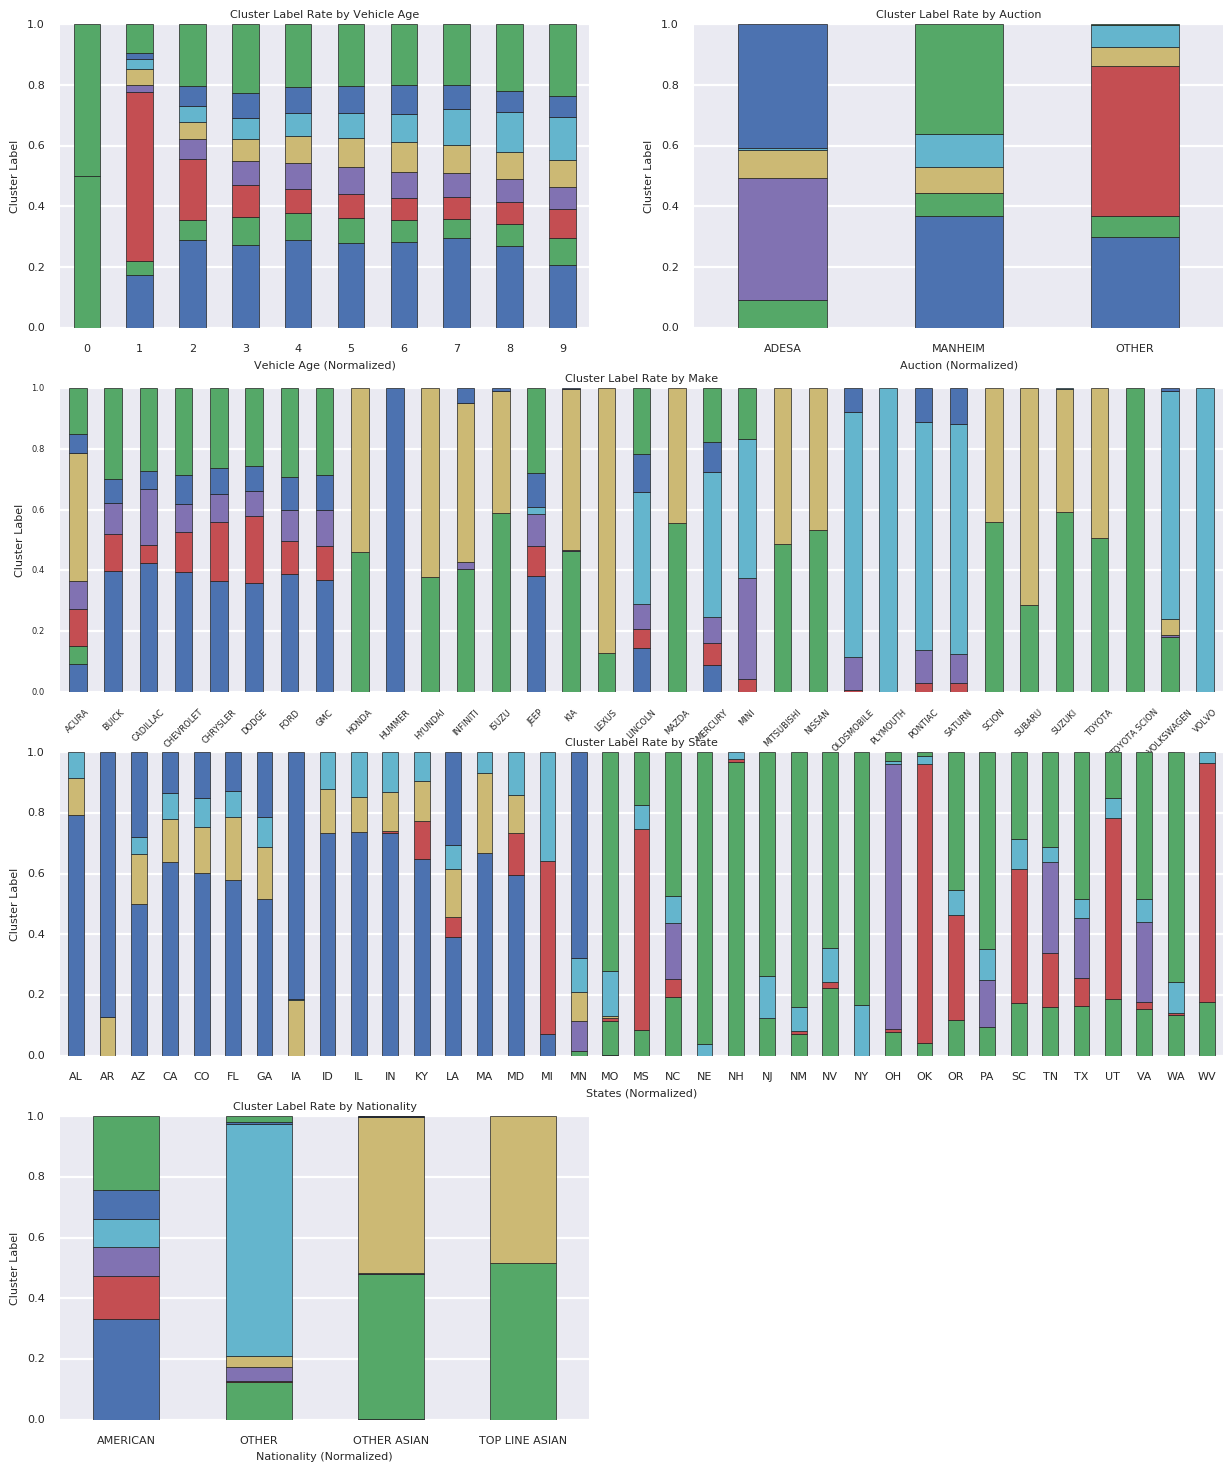

In [43]:
# Cluster Distribution for each attribute
fig = plt.figure(figsize=(15,18))
ax1 = plt.subplot2grid((4,2), (0,0))
ax2 = plt.subplot2grid((4,2), (0,1))
ax3 = plt.subplot2grid((4,2), (1,0),colspan=2)
ax4 = plt.subplot2grid((4,2), (2,0),colspan=2)
ax5 = plt.subplot2grid((4,2), (3,0))
#ax6 = plt.subplot2grid((4,2), (3,1))

dfClusters = dfCluster2.copy()
dfClusters['kMeansLabels'] = kmeans.labels_

# Vehicle Age
xtab_VehicleAge = pd.crosstab(dfClusters['VehicleAge'],dfClusters['kMeansLabels'])
pctVehicleAge = xtab_VehicleAge.div(xtab_VehicleAge.sum(1).astype(float), axis=0)

pctVehicleAge.plot(kind='bar', stacked=True, ax=ax1, legend=None)
ax1.set_xlabel('Vehicle Age (Normalized)', fontsize=8)
ax1.set_ylabel('Cluster Label', fontsize=8)
ax1.set_title('Cluster Label Rate by Vehicle Age', fontsize=8)
ax1.set_xticklabels(vehicleAges, rotation=0)
ax1.tick_params(axis='x', labelsize=8)
ax1.tick_params(axis='y', labelsize=8)

# Auction
xtab_AuctionVal = pd.crosstab(dfClusters['AuctionVal'],dfClusters['kMeansLabels'])
pctAuctionVal = xtab_AuctionVal.div(xtab_AuctionVal.sum(1).astype(float), axis=0)

pctAuctionVal.plot(kind='bar', stacked=True, ax=ax2, legend=None)
ax2.set_xlabel('Auction (Normalized)', fontsize=8)
ax2.set_ylabel('Cluster Label', fontsize=8)
ax2.set_title('Cluster Label Rate by Auction', fontsize=8)
ax2.set_xticklabels(auctions, rotation=0)
ax2.tick_params(axis='x', labelsize=8)
ax2.tick_params(axis='y', labelsize=8)

# Make
xtab_MakeVal = pd.crosstab(dfClusters['MakeVal'],dfClusters['kMeansLabels'])
pctMakeVal = xtab_MakeVal.div(xtab_MakeVal.sum(1).astype(float), axis=0)

pctMakeVal.plot(kind='bar', stacked=True, ax=ax3, legend=None)
ax3.set_xlabel('Make (Normalized)', fontsize=8)
ax3.set_ylabel('Cluster Label', fontsize=8)
ax3.set_title('Cluster Label Rate by Make', fontsize=8)
ax3.set_xticklabels(makes, rotation=45)
ax3.tick_params(axis='x', labelsize=6)
ax3.tick_params(axis='y', labelsize=6)

# State
xtab_States = pd.crosstab(dfClusters['VNSTVal'],dfClusters['kMeansLabels'])
pctStates = xtab_States.div(xtab_States.sum(1).astype(float), axis=0)

pctStates.plot(kind='bar', stacked=True, ax=ax4, legend=None)
ax4.set_xlabel('States (Normalized)', fontsize=8)
ax4.set_ylabel('Cluster Label', fontsize=8)
ax4.set_title('Cluster Label Rate by State', fontsize=8)
ax4.set_xticklabels(states, rotation=0)
ax4.tick_params(axis='x', labelsize=8)
ax4.tick_params(axis='y', labelsize=8)

# Nationality
xtab_NationalityVal = pd.crosstab(dfClusters['NationalityVal'],dfClusters['kMeansLabels'])
pctNationalityVal = xtab_NationalityVal.div(xtab_NationalityVal.sum(1).astype(float), axis=0)

pctNationalityVal.plot(kind='bar', stacked=True, ax=ax5, legend=None)
ax5.set_xlabel('Nationality (Normalized)', fontsize=8)
ax5.set_ylabel('Cluster Label', fontsize=8)
ax5.set_title('Cluster Label Rate by Nationality', fontsize=8)
ax5.set_xticklabels(nationalities, rotation=0)
ax5.tick_params(axis='x', labelsize=8)
ax5.tick_params(axis='y', labelsize=8)

# Warranty Cost
#xtab_warranties = pd.crosstab(dfClusters['WarrantyCostVal'],dfClusters['kMeansLabels'])
#pctWarranties = xtab_warranties.div(xtab_warranties.sum(1).astype(float), axis=0)

#pctWarranties.plot(kind='bar', stacked=True, title='Cluster Label Rate by Warranty Cost', ax=ax6, legend=None)
#ax6.set_xlabel('Warranty Cost (Normalized)')
#ax6.set_ylabel('Cluster Label')

# ZIPCODE
#xtab_Zipcodes = pd.crosstab(dfClusters['VNZIP1Val'],dfClusters['kMeansLabels'])
#pctZipcodes = xtab_Zipcodes.div(xtab_Zipcodes.sum(1).astype(float), axis=0)

#pctZipcodes.plot(kind='bar', stacked=True, title='Cluster Label Rate by Zipcode', ax=ax4, legend=None)
#ax4.set_xlabel('Zipcode (Normalized)')
#ax4.set_ylabel('Cluster Label')

# Save plot image
plt.savefig('saved_plots/plots_clustering_label_rate.png')

plt.show()

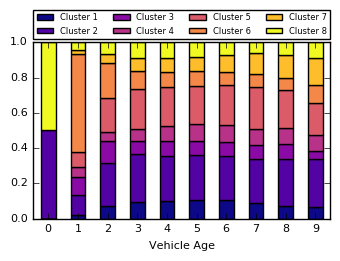

In [33]:
dfClusters = dfCluster2.copy()
dfClusters['kMeansLabels'] = kmeans.labels_

# Vehicle Age
xtab_VehicleAge = pd.crosstab(dfClusters['VehicleAge'],dfClusters['kMeansLabels'])
pctVehicleAge = xtab_VehicleAge.div(xtab_VehicleAge.sum(1).astype(float), axis=0)

# Plot Dimension
import matplotlib.cm as cm  #colormap

plt.figure(figsize=(3.5,2.5))
ax1 = plt.subplot(111)

pctVehicleAge.plot(kind='bar', stacked=True, ax=ax1, cmap='plasma')
ax1.set_xlabel('Vehicle Age', fontsize=8)
#ax1.set_ylabel('Cluster Label', fontsize=8)
#ax1.set_title('Cluster Label Rate by Vehicle Age', fontsize=8)
ax1.set_axis_bgcolor('white')
ax1.set_xticklabels(vehicleAges, rotation=0)
ax1.tick_params(axis='x', labelsize=8)
ax1.tick_params(axis='y', labelsize=8)
labels = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6','Cluster 7','Cluster 8',]
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=4, mode="expand", borderaxespad=0.,fontsize=6,labels=labels)

plt.tight_layout()

# Save plot image
plt.savefig('saved_plots/plots_clustering_kmean_vehicleage.png')

plt.show()

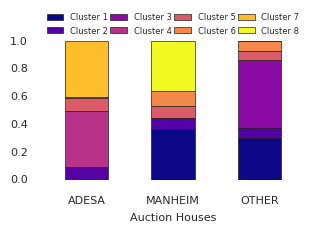

In [88]:
dfClusters = dfCluster2.copy()
dfClusters['kMeansLabels'] = kmeans.labels_

# Plot Dimension
import matplotlib.cm as cm  #colormap

plt.figure(figsize=(3.5,2.5))
ax1 = plt.subplot(111)

# Auction
xtab_AuctionVal = pd.crosstab(dfClusters['AuctionVal'],dfClusters['kMeansLabels'])
pctAuctionVal = xtab_AuctionVal.div(xtab_AuctionVal.sum(1).astype(float), axis=0)

pctAuctionVal.plot(kind='bar', stacked=True, ax=ax1, cmap='plasma')
ax1.set_xlabel('Auction Houses', fontsize=8)
ax1.set_axis_bgcolor('white')
#ax1.set_ylabel('Cluster Label', fontsize=8)
#ax1.set_title('Cluster Label Rate by Auction', fontsize=8)
ax1.set_xticklabels(auctions, rotation=0)
ax1.tick_params(axis='x', labelsize=8)
ax1.tick_params(axis='y', labelsize=8)
labels = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6','Cluster 7','Cluster 8',]
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=4, mode="expand", borderaxespad=0.,fontsize=6,labels=labels)

plt.tight_layout()

# Save plot image
plt.savefig('saved_plots/plots_clustering_kmean_auctions.png')

plt.show()

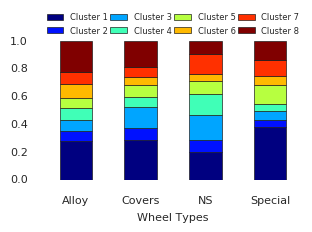

In [89]:
dfClusters = dfCluster2.copy()
dfClusters['kMeansLabels'] = kmeans.labels_

# Plot Dimension
import matplotlib.cm as cm  #colormap

plt.figure(figsize=(3.5,2.5))
ax1 = plt.subplot(111)

# WheelType
xtab_wheeltype = pd.crosstab(dfClusters['WheelTypeVal'],dfClusters['kMeansLabels'])
pctWheeltype = xtab_wheeltype.div(xtab_wheeltype.sum(1).astype(float), axis=0)

pctWheeltype.plot(kind='bar', stacked=True, ax=ax1, cmap='jet')
ax1.set_xlabel('Wheel Types', fontsize=8)
ax1.set_axis_bgcolor('white')
#ax1.set_ylabel('Cluster Label', fontsize=8)
#ax1.set_title('Cluster Label Rate by Auction', fontsize=8)
ax1.set_xticklabels(wheeltypes, rotation=0)
ax1.tick_params(axis='x', labelsize=8)
ax1.tick_params(axis='y', labelsize=8)
labels = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6','Cluster 7','Cluster 8',]
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=4, mode="expand", borderaxespad=0.,fontsize=6,labels=labels)

plt.tight_layout()

# Save plot image
plt.savefig('saved_plots/plots_clustering_kmean_wheels.png')

plt.show()

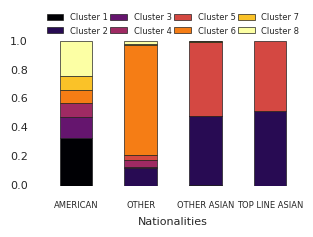

In [90]:
dfClusters = dfCluster2.copy()
dfClusters['kMeansLabels'] = kmeans.labels_

# Plot Dimension
import matplotlib.cm as cm  #colormap

plt.figure(figsize=(3.5,2.5))
ax1 = plt.subplot(111)

# Nationality
xtab_NationalityVal = pd.crosstab(dfClusters['NationalityVal'],dfClusters['kMeansLabels'])
pctNationalityVal = xtab_NationalityVal.div(xtab_NationalityVal.sum(1).astype(float), axis=0)

pctNationalityVal.plot(kind='bar', stacked=True, ax=ax1, cmap='inferno')
ax1.set_xlabel('Nationalities', fontsize=8)
ax1.set_axis_bgcolor('white')
#ax1.set_ylabel('Cluster Label', fontsize=8)
#ax1.set_title('Cluster Label Rate by Nationality', fontsize=8)
ax1.set_xticklabels(nationalities, rotation=0)
ax1.tick_params(axis='x', labelsize=6)
ax1.tick_params(axis='y', labelsize=8)
labels = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6','Cluster 7','Cluster 8',]
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=4, mode="expand", borderaxespad=0.,fontsize=6,labels=labels)

plt.tight_layout()

# Save plot image
plt.savefig('saved_plots/plots_clustering_kmean_nationalities.png')

plt.show()

In [18]:
# kmeans silhouette

print "kmeans"
nClusters = 8
kmeans = KMeans(n_clusters = nClusters).fit(cluster2Array)

print "Attributes: ", dfCluster2.columns

hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
print 'labels', dict(zip(bins, hist))
print 'silhouette', silhouette_score(cluster2Array, kmeans.labels_,sample_size=20000)

kmeans
Attributes:  Index([u'VehOdo', u'WarrantyCostVal'], dtype='object')
labels {0: 10024, 1: 7372, 2: 8821, 3: 5965, 4: 10098, 5: 9276, 6: 10572, 7: 10855}
silhouette 0.377719135786


In [ ]:
# VehOdo + VehBCost -> 0.34
# VehOdo + WarrantyCost -> 0.36(10k),
# VehBCost + WarrantyCost -> 0.39
# 
# VehOdo + VehBCost + WarrantyCost -> 0.31
#
#
# VehOdo + VehBCost + VehicleAge -> 0.32
# VehOdo + VehBCost + VehicleAge + WarrantyCost -> 0.26
#
#
#

In [50]:
# Hierarchical Clustering
connectivity = kneighbors_graph(cluster2Array, n_neighbors=100, include_self=False)
connectivity = 0.5 * (connectivity + connectivity.T)

In [56]:
print 'ward'
ward = AgglomerativeClustering(n_clusters=8, linkage='ward', affinity='euclidean',
                                   connectivity=connectivity)
ward.fit(cluster2Array)

hist, bins = np.histogram(ward.labels_, bins=range(0, len(set(ward.labels_)) + 1))
print 'labels', dict(zip(bins, hist))
print 'silhouette', silhouette_score(cluster2Array, ward.labels_,sample_size=30000)

ward
labels {0: 11796, 1: 8419, 2: 13267, 3: 7557, 4: 16205, 5: 4819, 6: 5926, 7: 4994}
silhouette 0.20192226954


In [53]:
print 'average linkage'
average_linkage = AgglomerativeClustering(n_clusters=8, linkage='average', affinity='manhattan',
                                              connectivity=connectivity)
average_linkage.fit(cluster2Array)

hist, bins = np.histogram(average_linkage.labels_, 
                          bins=range(0, len(set(average_linkage.labels_)) + 1))

print 'labels', dict(zip(bins, hist))
print 'silhouette', silhouette_score(cluster2Array, average_linkage.labels_,sample_size=15000)

average linkage
labels {0: 72962, 1: 11, 2: 2, 3: 1, 4: 1, 5: 4, 6: 1, 7: 1}
silhouette 0.145963230755


In [16]:
print 'complete linkage'
complete_linkage = AgglomerativeClustering(n_clusters=8, linkage='complete', affinity='l1',
                                              connectivity=connectivity)
complete_linkage.fit(cluster2Array)
hist, bins = np.histogram(complete_linkage.labels_, 
                          bins=range(0, len(set(complete_linkage.labels_)) + 1))

print 'labels', dict(zip(bins, hist))
print 'silhouette', silhouette_score(cluster2Array, complete_linkage.labels_,sample_size=15000)

complete linkage
labels {0: 35572, 1: 1115, 2: 1675, 3: 12, 4: 2478, 5: 32131}
silhouette 0.0220693301629


In [ ]:
# Split Dataset
# Well, hierarchical clustering doesn't make that much sense for large datasets. 
# It's actually mostly a textbook example in my opinion. 
# The problem with hierarchical clustering is that it doesn't really build sensible clusters. 
# It builds a dendrogram, but with 14000 objects the dendrogram becomes pretty much unusable. 
# And very few implementations of hierarchical clustering have non-trivial methods to extract sensible clusters 
# from the dendrogram. Plus, in the general case, hierarchical clustering is of complexity O(n^3) which makes 
# it scale really bad to large datasets.

# It's possible that you really are running out of RAM. Finding pairwise distances between N objects means storing N^2 distances. 
# In your case, N^2 is going to be 14039 ^ 2 = 1.97 * 10^8. If we assume that each distance takes only four bytes 
# (which is almost certainly not the case, as they have to be held in some sort of data structure which may have non-constant 
#  overhead) that works out to 800 megabytes. That's a lot of memory for the interpreter to be working with. 
# 32-bit architectures only allow up to 2 GB of process memory, and just your raw data is taking up around 50% of that. 
# With the overhead of the data structure you could be looking at usage much higher than that 
# -- I can't say how much because I don't know the memory model behind SciPy/numpy.

# I would try breaking your data sets up into smaller sets, or not constructing the full distance matrix. 
# You can break it down into more manageable chunks (say, 14 subsets of around 1000 elements) and do nearest-neighbor 
# between each chunk and all of the vectors -- then you're looking at loading an order of magnitude less into memory 
# at any one time (14000 * 1000, 14 times instead of 14000 * 14000 once).

In [27]:
# numpy.array_split
# Identical to numpy.split, but won't raise an exception if the groups aren't equal length.

# Split Dataset Numpy Array in subsets for resolve memory problems with a large dataset while generate a linkage matrix

nSubsets = 3
dataset_subsets = np.array_split(cluster2Array,nSubsets)

In [28]:
# check subset 1 dimension
print len(dataset_subsets[0]),

24328


In [16]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import mode
from scipy.spatial.distance import pdist

In [17]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        #plt.title('Hierarchical Clustering Dendrogram (truncated)')
        #plt.xlabel('cluster size',fontsize=6)
        #plt.ylabel('distance',fontsize=6)
        # remove labels from axis x
        plt.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom='off',      # ticks along the bottom edge are off
            top='off',         # ticks along the top edge are off
            labelbottom='off') # labels along the bottom edge are off
        
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center',fontsize=8)
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [33]:
# Linkage (from Scipy lib)
# The following are methods for calculating the distance between the newly formed cluster u and each v.
#
# single linkage
# complete linkage
# average linkage
# weighted linkage
# ward linkage

# Metrics
# euclidean (default)
# https://en.wikipedia.org/wiki/Hierarchical_clustering for others metrics
#

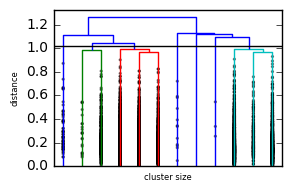

In [47]:
# Single Linkage + Euclidean

# generate the linkage matrix
#data_link = linkage(dataset_subsets[0], method='single', metric='euclidean')

# single linkage
data_dist = pdist(dataset_subsets[0], metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidean')

plt.figure(figsize=(3,2))
ax1 = plt.subplot(111)

# max distance
max_d = 1.02

# Dendogram
ax1 = fancy_dendrogram(
    data_link,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,
)

plt.tight_layout()

# Save plot image
plt.savefig('saved_plots/plots_clustering_dendogram_1.png')

plt.show()

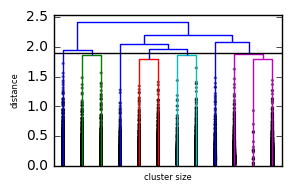

In [51]:
# Complete Linkage + Euclidean

# generate the linkage matrix
#data_link = linkage(dataset_subsets[0], method='single', metric='euclidean')

# single linkage
data_dist = pdist(dataset_subsets[0], metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')

plt.figure(figsize=(3,2))
ax1 = plt.subplot(111)

# max distance
max_d = 1.9

# Dendogram
ax1 = fancy_dendrogram(
    data_link,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,
)

plt.tight_layout()

# Save plot image
plt.savefig('saved_plots/plots_clustering_dendogram_2.png')

plt.show()

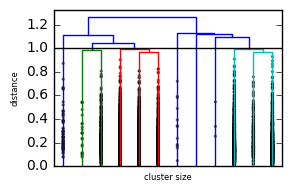

In [52]:
# Average Linkage + Euclidean

# generate the linkage matrix
#data_link = linkage(dataset_subsets[0], method='single', metric='euclidean')

# single linkage
data_dist = pdist(dataset_subsets[0], metric='euclidean')
data_link = linkage(data_dist, method='average', metric='euclidean')

plt.figure(figsize=(3,2))
ax1 = plt.subplot(111)

# max distance
max_d = 1

# Dendogram
ax1 = fancy_dendrogram(
    data_link,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,
)

plt.tight_layout()

# Save plot image
plt.savefig('saved_plots/plots_clustering_dendogram_3.png')

plt.show()

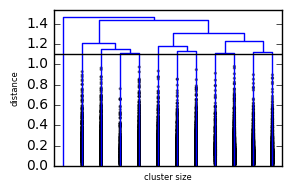

In [55]:
# Weighted Linkage + Euclidean

# generate the linkage matrix
#data_link = linkage(dataset_subsets[0], method='single', metric='euclidean')

# single linkage
data_dist = pdist(dataset_subsets[0], metric='euclidean')
data_link = linkage(data_dist, method='weighted', metric='euclidean')

plt.figure(figsize=(3,2))
ax1 = plt.subplot(111)

# max distance
max_d = 1.1

# Dendogram
ax1 = fancy_dendrogram(
    data_link,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,
)

plt.tight_layout()

# Save plot image
plt.savefig('saved_plots/plots_clustering_dendogram_4.png')

plt.show()

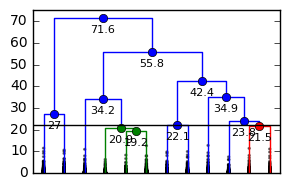

In [18]:
# Ward Linkage + Euclidean

# generate the linkage matrix
#data_link = linkage(dataset_subsets[0], method='single', metric='euclidean')

# single linkage
data_dist = pdist(dataset_subsets[0], metric='euclidean')
data_link = linkage(data_dist, method='ward', metric='euclidean')

plt.figure(figsize=(3,2))
ax1 = plt.subplot(111)

# max distance
max_d = 22

# Dendogram
ax1 = fancy_dendrogram(
    data_link,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=max_d,
)

plt.tight_layout()

# Save plot image
plt.savefig('saved_plots/plots_clustering_dendogram_5.png')

plt.show()

In [6]:
from sklearn.preprocessing import StandardScaler

df_tmp = pd.concat([df['WarrantyCost'],df['VehBCost'],df['VehOdo'],df['VehicleAge']],axis=1)
data_array = StandardScaler().fit_transform(df_tmp)


In [7]:
# set samples
data_array_samples = data_array[:,:]

print "N. Samples:",len(data_array_samples)
print data_array_samples[:10]

N. Samples: 72983
[[-0.27316186  0.20876712  1.2035276  -0.68721228]
 [-0.37335512  0.49159905  1.51541855  0.48087654]
 [ 0.18772712 -1.03569339  0.15824361 -0.10316787]
 [-1.0797176  -1.48822449 -0.40353051  0.48087654]
 [-0.42846142 -1.54479087 -0.14630793 -0.10316787]
 [-1.13983355 -0.63972868  0.65533483  0.48087654]
 [-1.2416967  -1.4316581  -0.4233538   0.48087654]
 [-0.75408951 -1.26195894 -0.39063508 -0.10316787]
 [-1.32686097 -0.63972868 -1.48016135 -1.27125669]
 [ 0.59517971  0.54816544  0.91722171 -1.27125669]]


Unique Labels: set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, -1])


/home/matteo/anaconda2/lib/python2.7/site-packages/matplotlib/lines.py:1145: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if self._markerfacecolor != fc:


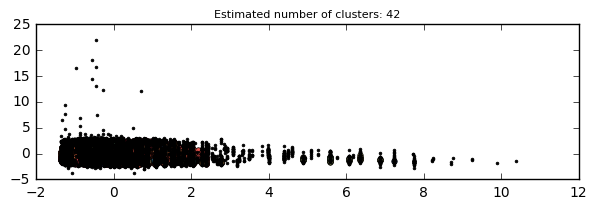

In [8]:
# Plotting with DBSCAN

fig = plt.figure(figsize=(7,2))
ax1 = plt.subplot(111)

db = DBSCAN(eps=0.3, min_samples=10).fit(data_array_samples)
labels = db.labels_
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Black removed and is used for noise instead.
unique_labels = set(labels)
print "Unique Labels:",unique_labels
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = 'k'

    class_member_mask = (labels == k)

    xy = data_array_samples[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', 
             markerfacecolor=col,
             markeredgecolor='k', 
             markersize=4)

    xy = data_array_samples[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', 
             markerfacecolor=col,
             markeredgecolor='k', 
             markersize=2)

plt.title('Estimated number of clusters: %d' % n_clusters_,fontsize=8)

# Save plot image
#plt.savefig('saved_plots/plots_clustering_dbscan.png')

plt.show()

In [9]:
# DBSCAN Silhouette Scoring
dbscan = DBSCAN(eps=0.2, min_samples=5, metric='euclidean')

dbscan.fit(data_array_samples)

hist, bins = np.histogram(dbscan.labels_, bins=range(-1, len(set(dbscan.labels_)) + 1))

print "Attributes: ",df_tmp.columns
print "N.Samples: ",len(df_tmp)
print "Silhouette Score with DBSCAN"
print 'labels', dict(zip(bins, hist))
print 'silhouette score', silhouette_score(data_array_samples, dbscan.labels_,sample_size=10000)


Attributes:  Index([u'WarrantyCost', u'VehBCost', u'VehOdo', u'VehicleAge'], dtype='object')
N.Samples:  72983
Silhouette Score with DBSCAN
labels {0: 15066, 1: 11644, 2: 15814, 3: 6420, 4: 6283, 5: 2685, 6: 9, 7: 33, 8: 6, 9: 1372, 10: 75, 11: 5, 12: 7, 13: 41, 14: 9, 15: 7, 16: 97, 17: 13, 18: 33, 19: 252, 20: 8, 21: 124, 22: 2048, 23: 7, 24: 37, 25: 9, 26: 66, 27: 5, 28: 22, 29: 28, 30: 7, 31: 25, 32: 9, 33: 28, 34: 8, 35: 155, 36: 12, 37: 70, 38: 8, 39: 8, 40: 5, 41: 39, 42: 44, 43: 20, 44: 6, 45: 6, 46: 7, 47: 8, 48: 23, 49: 32, 50: 30, 51: 23, 52: 17, 53: 30, 54: 15, 55: 8, 56: 141, 57: 36, 58: 9, 59: 62, 60: 10, 61: 15, 62: 13, 63: 52, 64: 7, 65: 114, 66: 12, 67: 10, 68: 15, 69: 7, 70: 8, 71: 16, 72: 8, 73: 6, 74: 4, 75: 9, 76: 17, 77: 13, 78: 8, 79: 8, 80: 17, 81: 7, 82: 5, 83: 12, 84: 8, 85: 6, 86: 17, 87: 29, 88: 17, 89: 9, 90: 6, 91: 10, 92: 7, 93: 6, 94: 10, 95: 7, 96: 11, 97: 5, 98: 7, 99: 7, 100: 18, 101: 8, 102: 7, 103: 6, 104: 23, 105: 9, 106: 11, 107: 13, 108: 7, 109: 

In [ ]:
# DBSCAN Scoring
# VehicleAge + VehOdo -> 0.14
# VehicleAge + VehOdo + WheelTypeVal -> 0.13
# VehicleAge + WarrantyCost -> 0.16
# VehicleAge + VehBCost + Warranty -> - 0.19
# VehBCost + WarrantyCost - > 0.29 (20k samples), 0.36 (30k samples), 0.408465325813 (40k), 
# WarrantyCost + VehOdo + VehBCost -> - 0.43
# WarrantyCost + VehOdo -> 0.08

In [ ]:
# CALCOLARE LE VARIE SILHOUETTE! e metterle nella relazione

C:\Users\giulen\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\giulen\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\Users\giulen\Anaconda2\lib\site-packages\sklearn\preprocessing\data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single 

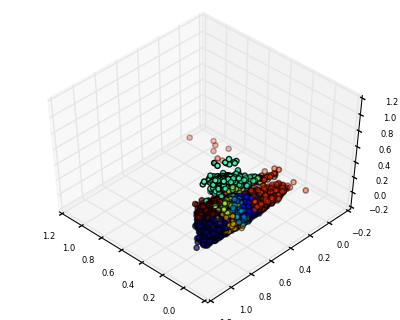

In [67]:
# VehicleAge
# VehOdo
# VehBCost

from mpl_toolkits.mplot3d import Axes3D

df_tmp = pd.concat([df['VehBCost'],df['VehOdo'],df['WarrantyCost']],axis=1)
#df_tmp = df_tmp[:]
min_max_scaler = preprocessing.MinMaxScaler()

for k in df_tmp.columns:
    df_tmp[k] = min_max_scaler.fit_transform(df_tmp[k].values.astype(float))

data_array = df_tmp.values

fig = plt.figure(figsize=(4,3))
ax1 = plt.subplot(111)

ax1 = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
kmean = KMeans(n_clusters=8).fit(data_array)
labels = kmean.labels_

ax1.scatter(
    data_array[:,0],data_array[:,1],data_array[:,2], c=labels, s=14)

ax1.tick_params(axis='x', labelsize=6)
ax1.tick_params(axis='y', labelsize=6)
ax1.tick_params(axis='z', labelsize=6)

plt.show()
plt.savefig('saved_plots/plots_clustering_kmean_3d.png')

In [13]:
# Prediction

nClusters = 8

# DataFrame with selected attributes (after clustering analysis)
dfCluster2 = pd.concat([
    df['NationalityVal'],
    df['AuctionVal'],
    df['MakeVal'],
    df['VNSTVal'],
    df['VNZIP1Val'],
    ],
    axis=1)

cluster2Array = dfCluster2.values
target = df['IsBadBuy'].values

kmeans2 = KMeans(init='k-means++', n_clusters=nClusters, n_init=10, max_iter=100)
kmeans2.fit(cluster2Array, target)
prediction = kmeans2.predict(cluster2Array)

# Scoring
print(kmeans2.score(cluster2Array, target))
print 'sse', kmeans2.inertia_ 
print 'silhouette', silhouette_score(cluster2Array, kmeans2.labels_,sample_size=10000)

# DataFrame with RefID and IsBadBuy
refID = np.array(df['RefId']).astype(int)
solution = pd.DataFrame(prediction,refID,columns=['IsBadBuy'])
print solution.head()
solution.to_csv('solution_kmeans.csv', index_label= ['RefId'])

[0 0 0 0 0]
-8022383.14598
sse 8022383.14598
silhouette 0.49120986962
   IsBadBuy
1         3
2         3
3         3
4         3
5         3


In [ ]:
fig = plt.figure(figsize=(6,5))

ax1 = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax1.scatter(df['VehicleAge'][:1000].values, df['VehOdo'][:1000].values, df['SizeVal'][:1000].values, c=df['MakeVal'][:1000])


plt.show()

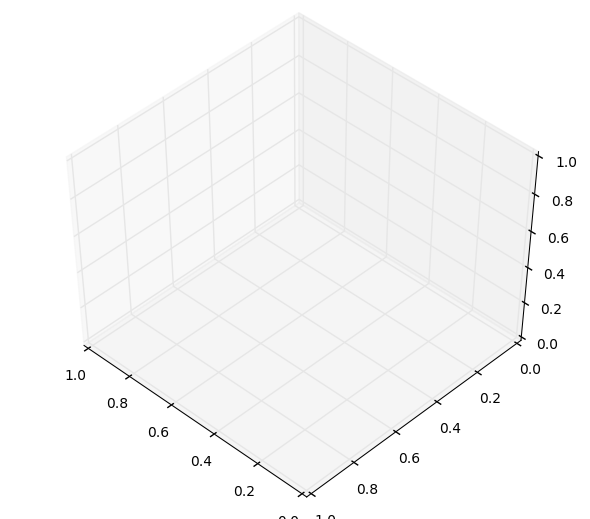

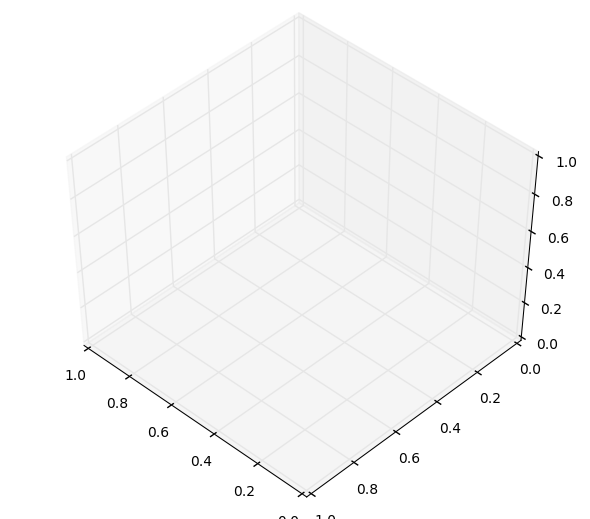

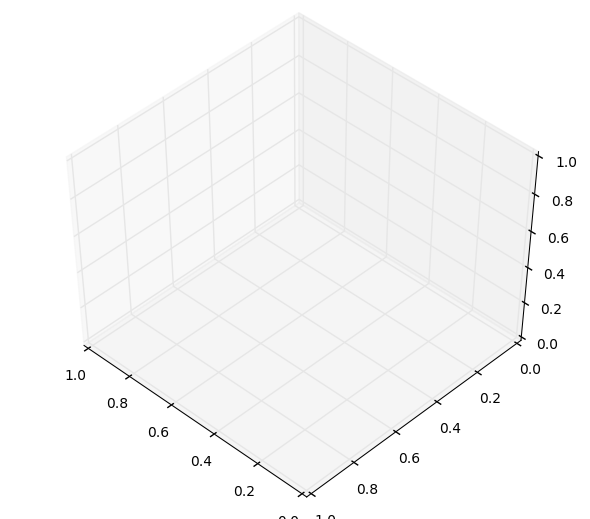

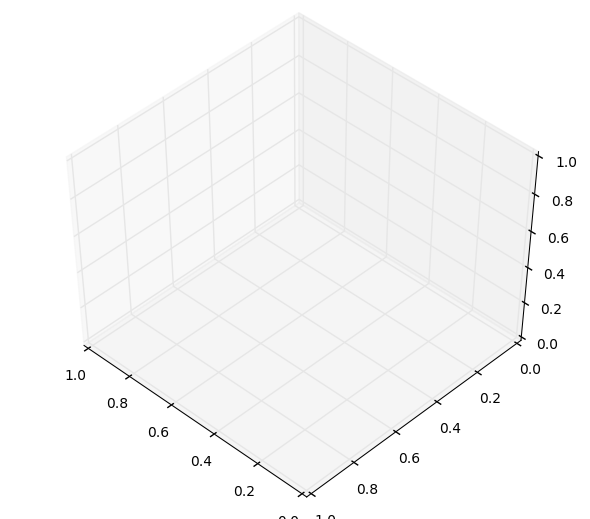

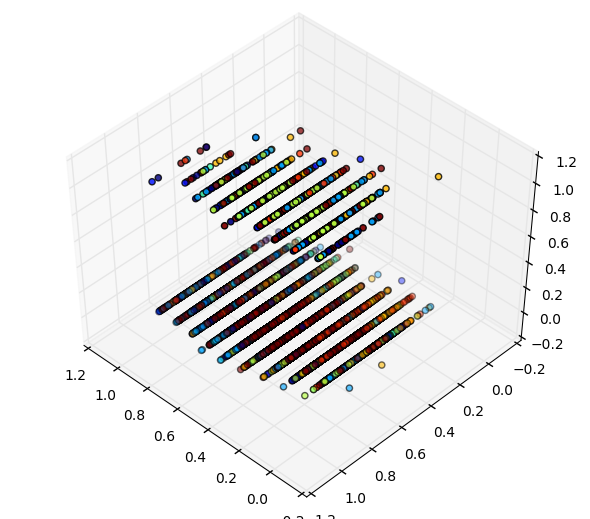

In [21]:
fig = plt.figure(figsize=(6,5))

kmeans = KMeans(init='k-means++', n_clusters=8, n_init=10, max_iter=100)
kmeans.fit(cluster1Array)

ax1 = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
ax1.scatter(cluster1Array[:, 0], cluster1Array[:, 1], cluster1Array[:, 2], c=kmeans.labels_.astype(np.float))

plt.show()